# Préparation des données

In [1]:
import pandas as pd

full_df = pd.read_csv("synthetic.csv")

# Mettre de coté 20% des données pour le test
test_df = full_df.sample(frac=0.2, random_state=0)
df = full_df.drop(test_df.index)

##### Q1
print("Nombre d'attributs des données :", df.columns.size - 1)

##### Q2
print(
    "Nombre des classes différentes dans les instances :",
    df["Class"].value_counts().count(),
)

##### Q3
print(
    "Nombre d'instances pour chaque classe :\n",
    df["Class"].value_counts().sort_index(),
    sep="",
)

Nombre d'attributs des données : 14
Nombre des classes différentes dans les instances : 4
Nombre d'instances pour chaque classe :
Class
0    510
1    727
2    387
3    214
Name: count, dtype: int64


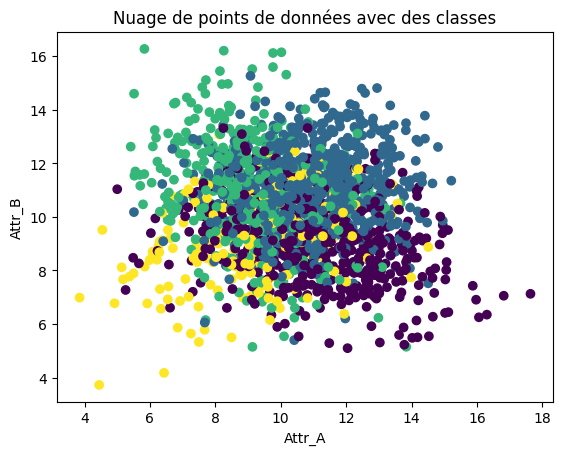

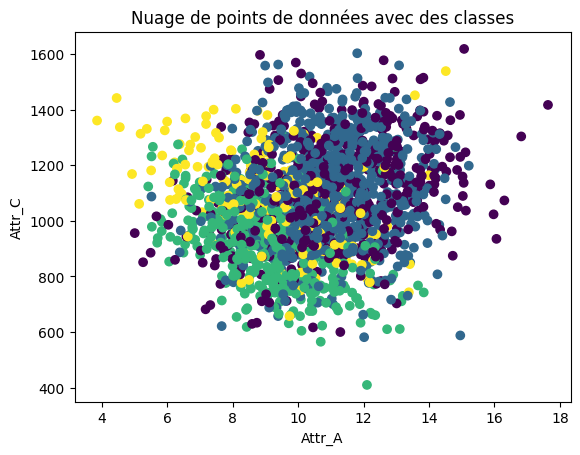

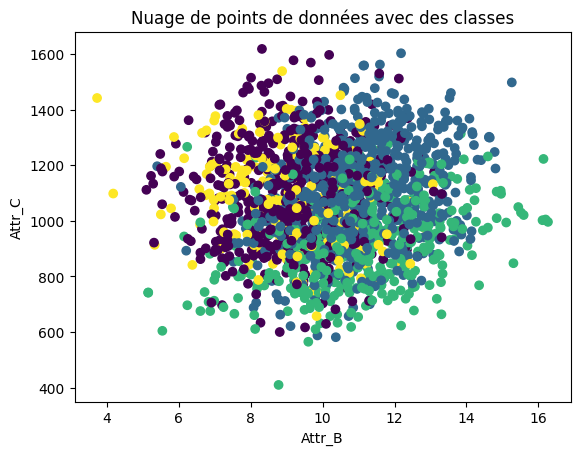

In [2]:
##### Q4
import matplotlib.pyplot as plt

# Visualisation 2 à 2 de quelques attributs avec les classes
plt.scatter(df["Attr_A"], df["Attr_B"], c=df["Class"])
plt.xlabel("Attr_A")
plt.ylabel("Attr_B")
plt.title("Nuage de points de données avec des classes")
plt.show()

plt.scatter(df["Attr_A"], df["Attr_C"], c=df["Class"])
plt.xlabel("Attr_A")
plt.ylabel("Attr_C")
plt.title("Nuage de points de données avec des classes")
plt.show()

plt.scatter(df["Attr_B"], df["Attr_C"], c=df["Class"])
plt.xlabel("Attr_B")
plt.ylabel("Attr_C")
plt.title("Nuage de points de données avec des classes")
plt.show()

# Mise en œuvre des modèles

## Arbre de décision

In [3]:
# Gain, entropie et la recherche du meilleur attribut pour le split avec des quartiles

from math import log2
from typing import List, Tuple

from pandas import DataFrame


def entropie(dataframe: DataFrame, attribut_cible: str = "Class") -> float:
    sum: float = 0
    total: int = len(dataframe)
    for c in dataframe[attribut_cible].value_counts():
        sum += (c / total) * log2((c / total))
    return -sum


def best_split(
    dataframe: DataFrame, a: str, attribut_cible: str = "Class"
) -> Tuple[float, float, List[DataFrame]]:
    """Calcul des détails du meilleur split pour un attribut donné

    Args:
        dataframe: le dataframe contenant les données à partitionner
        a: attribut dont on cherche à déterminer le gain
        attribut_cible: attribut que l'on souhaite prédire

    """

    sorted_data: DataFrame = dataframe.sort_values(a)

    # On calcule le quartile 1 pour le départ
    split_value: float = sorted_data[a].quantile(0.25)
    partitions: List[DataFrame] = [
        sorted_data[sorted_data[a] < split_value],
        sorted_data[sorted_data[a] >= split_value],
    ]
    gain: float = calculate_gain(dataframe, partitions, a, attribut_cible)

    for q in [0.5, 0.75]:  # On teste les quartiles 2 et 3
        q_split: float = sorted_data[a].quantile(q)
        q_low: DataFrame = sorted_data[sorted_data[a] < q_split]
        q_high: DataFrame = sorted_data[sorted_data[a] >= q_split]
        local_gain: float = calculate_gain(
            dataframe, [q_low, q_high], a, attribut_cible
        )
        if local_gain > gain:
            gain = local_gain
            split_value = q_split
            partitions = [q_low, q_high]

    return (gain, split_value, partitions)


def calculate_gain(
    dataframe: DataFrame,
    partitions: List[DataFrame],
    a: str,
    attribut_cible: str = "Class",
) -> float:
    """Calcul du gain pour un attribut donné

    Args:
        dataframe: le dataframe contenant toutes les données
        partitions: les partitions obtenues après le split
        a: attribut dont on cherche à déterminer le gain
        attribut_cible: attribut que l'on souhaite prédire

    """

    e: float = entropie(dataframe, attribut_cible)
    sum: float = 0
    total: int = len(dataframe)
    for p in partitions:
        sum += (len(p[a]) / total) * entropie(p, attribut_cible)
    return e - sum


def best_feature(
    dataframe: DataFrame, attributs: List[str], attribut_cible: str = "Class"
) -> Tuple[str, float, float, List[DataFrame]]:
    """Calcul de l'attribut qui donne le meilleur gain et son split

    Args:
        dataframe: le dataframe contenant toutes les données
        attribut_cible: attribut que l'on souhaite prédire

    """
    attributs_copy: List[str] = attributs.copy()
    best_result: tuple = best_split(dataframe, attributs_copy[0], attribut_cible)
    best_feature_label: str = attributs_copy.pop(0)

    for a in attributs_copy:
        result = best_split(dataframe, a, attribut_cible)
        if result[0] > best_result[0]:
            best_result = result
            best_feature_label = a

    return (best_feature_label,) + best_result


def best_feature_wrapper(
    dataframe: DataFrame, attribut_cible: str = "Class"
) -> Tuple[str, float, float, List[DataFrame]]:
    """Calcul de l'attribut qui donne le meilleur gain et son split

    Args:
        dataframe: le dataframe contenant toutes les données
        attribut_cible: attribut que l'on souhaite prédire

    """
    attributs: List[str] = dataframe.columns.tolist()
    attributs.remove(attribut_cible)
    return best_feature(dataframe, attributs, attribut_cible)


print("Entropie de l'ensemble de données :", entropie(df))

feature, gain, split, partitions = best_feature_wrapper(df)
print("Meilleur attribut pour le split :", feature)
print("Gain obtenu :", gain)
print("Valeur de split :", split)
print("Nombre d'instances dans la partition 1 :", len(partitions[0]))
print("Nombre d'instances dans la partition 2 :", len(partitions[1]))
# print("Partitions obtenues :", partitions)

Entropie de l'ensemble de données : 1.876976207319886
Meilleur attribut pour le split : Attr_B
Gain obtenu : 0.16345382102161543
Valeur de split : 10.28594336957628
Nombre d'instances dans la partition 1 : 919
Nombre d'instances dans la partition 2 : 919


In [4]:
# Les noeuds, la construction de l'arbre et l'affichage

from typing import Optional

from pandas import Series


class Noeud:
    def __init__(
        self,
        prediction: Series,
        attribut: str | None = None,
        split: float | None = None,
        fils_gauche: Optional["Noeud"] = None,
        fils_droite: Optional["Noeud"] = None,
        feuille: bool = False,
    ) -> None:
        if feuille and attribut is not None:
            raise ValueError("Une feuille ne doit pas avoir d'attribut")
        if feuille and split is not None:
            raise ValueError("Une feuille ne doit pas avoir de valeur de split")
        if not feuille and (fils_gauche is None or fils_droite is None):
            raise ValueError("Un noeud interne doit avoir deux fils")
        if not feuille and split is None:
            raise ValueError("Un noeud interne doit avoir une valeur de split")
        if not feuille and attribut is None:
            raise ValueError("Un noeud interne doit avoir un attribut")

        self.attribut = attribut
        self.split = split
        self.prediction = prediction
        self.fils_gauche = fils_gauche
        self.fils_droite = fils_droite
        self.feuille = feuille

    def node_result(self, spacing: str = "") -> str:
        s = ""
        for v in range(len(self.prediction.values)):
            s += (
                " Class "
                + str(self.prediction.index[v])
                + " Count: "
                + str(self.prediction.values[v])
                + "\n"
                + spacing
            )
        return s


def print_tree(node: Noeud | None, spacing: str = "") -> None:
    if node is None:
        return

    if node.feuille:
        print(spacing + node.node_result(spacing))
        return

    print(
        "{}[Attribute: {}  Split value: {}]".format(spacing, node.attribut, node.split)
    )

    print(spacing + "> True")
    print_tree(node.fils_gauche, spacing + "-")

    print(spacing + "> False")
    print_tree(node.fils_droite, spacing + "-")
    return


# Je ne sais pas si c'est la bonne façon de déterminer si une partition est vide
def partitions_est_vide(partitions: List[DataFrame]) -> bool:
    if len(partitions) == 0:
        return True
    for p in partitions:
        if len(p) == 0:
            return True
    return False


def construction_arbre(
    dataframe: DataFrame,
    profondeur: int,
    seuil: int,
    attributs: List[str],
    attribut_cible: str = "Class",
) -> Noeud:
    attribut, _, split, partitions = best_feature(dataframe, attributs, attribut_cible)
    prediction = dataframe[attribut_cible].value_counts()

    attributs_restants = attributs.copy()
    attributs_restants.remove(attribut)

    if (
        profondeur > seuil
        or len(attributs_restants) == 0
        or partitions_est_vide(partitions)
    ):
        return Noeud(prediction=prediction, feuille=True)

    branche_gauche = construction_arbre(
        partitions[0], profondeur + 1, seuil, attributs_restants, attribut_cible
    )
    branche_droite = construction_arbre(
        partitions[1], profondeur + 1, seuil, attributs_restants, attribut_cible
    )

    return Noeud(
        attribut=attribut,
        split=split,
        prediction=prediction,
        fils_gauche=branche_gauche,
        fils_droite=branche_droite,
    )


def construction_arbre_wrapper(
    dataframe: DataFrame, seuil: int, attribut_cible: str = "Class"
) -> Noeud:
    attributs = dataframe.columns.tolist()
    attributs.remove(attribut_cible)
    return construction_arbre(
        dataframe,
        0,
        seuil,
        attributs,
        attribut_cible,
    )


arbre = construction_arbre_wrapper(df, 3)
print_tree(arbre)

[Attribute: Attr_B  Split value: 10.28594336957628]
> True
-[Attribute: Attr_I  Split value: 9.614691771785136]
-> True
--[Attribute: Attr_F  Split value: 1011.536477696535]
--> True
---[Attribute: Attr_N  Split value: 103.8980653172784]
---> True
---- Class 0 Count: 151
---- Class 3 Count: 9
---- Class 2 Count: 7
---- Class 1 Count: 4
----
---> False
---- Class 0 Count: 29
---- Class 3 Count: 15
---- Class 2 Count: 11
---- Class 1 Count: 3
----
--> False
---[Attribute: Attr_E  Split value: 90.44010319091998]
---> True
---- Class 3 Count: 40
---- Class 1 Count: 8
---- Class 0 Count: 8
---- Class 2 Count: 2
----
---> False
---- Class 2 Count: 87
---- Class 0 Count: 53
---- Class 3 Count: 26
---- Class 1 Count: 6
----
-> False
--[Attribute: Attr_J  Split value: 96.23362324249092]
--> True
---[Attribute: Attr_C  Split value: 1052.2908791696718]
---> True
---- Class 0 Count: 41
---- Class 1 Count: 38
---- Class 2 Count: 20
---- Class 3 Count: 16
----
---> False
---- Class 0 Count: 71
---- 

In [5]:
# Création des différents arbres de décision de profondeur 3 à 8 inclus

arbres: List[Noeud] = []

# Association indice de la liste à la profondeur de l'arbre
# arbres[0] = arbre de profondeur 3
# arbres[1] = arbre de profondeur 4
# ...
# arbres[5] = arbre de profondeur 8
for i in range(3, 9):
    arbres.append(construction_arbre_wrapper(df, i))

In [6]:
# Inférence et évaluation


from typing import cast


def inference(instance: DataFrame, noeud: Noeud) -> Series:
    if noeud.feuille:
        return noeud.prediction
    valeur_attribut: float = instance[noeud.attribut].values[0]
    # cast() est utilisé ici pour faire taire le vérificateur de type statique mypy
    # car on sait que le noeud n'est pas une feuille
    if valeur_attribut < cast(float, noeud.split):
        return inference(instance, cast(Noeud, noeud.fils_gauche))
    return inference(instance, cast(Noeud, noeud.fils_droite))


# Exemple d'erreur de classification
sample = test_df.loc[[1511]]
# sample = test_df.sample()
print(
    f"Inférence pour l'instance de label {sample['Class'].index[0]} et de class {sample['Class'].values[0]} :"
)
print(inference(sample, arbres[0]))  # Arbre de profondeur 3
print("\n")


# Evaluation de la précision sur les données de test
# pour les arbres de profondeur 3 à 8 inclus.
# Inférer chaque instance de test et comparer la prédiction
for i in range(3, 9):
    print("Profondeur de l'arbre :", i)
    correct: int = 0
    for _, row in test_df.iterrows():
        prediction = inference(row.to_frame().T, arbres[i - 3])
        if prediction.idxmax() == row["Class"]:
            correct += 1
    print("Précision :", round(correct / len(test_df) * 100, 3), "%", end="\n\n")

Inférence pour l'instance de label 1511 et de class 0 :
Class
1    130
0     21
3     19
2      2
Name: count, dtype: int64


Profondeur de l'arbre : 3
Précision : 70.217 %

Profondeur de l'arbre : 4
Précision : 75.435 %

Profondeur de l'arbre : 5
Précision : 76.957 %

Profondeur de l'arbre : 6
Précision : 80.0 %

Profondeur de l'arbre : 7
Précision : 75.435 %

Profondeur de l'arbre : 8
Précision : 75.0 %

